In [1]:
import fetching
import requests
import datetime
import pandas as pd
import numpy as np 
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
from collections import Counter
import copy
from operator import itemgetter
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Price data import 

We wrote a file 'fetching' which contains the different functions to import the data we will need from the api of the websites crypto-compare.com - for the price info - , blockchain.info - for all cryptocurrencies related data - and gdeltproject.org - for the media coverage data.

First we import the whole price history Bitcoin/USD

In [2]:
df = fetching.fetch.price_history('BTC', 'USD', True)
df.head(5)

,close,high,low,open,time,volumefrom,volumeto,timestamp
0,0.04951,0.04951,0.04951,0.04951,1279324800,20.00,0.9902,2010-07-17 02:00:00
1,0.08584,0.08585,0.05941,0.04951,1279411200,75.01,5.0900,2010-07-18 02:00:00
2,0.08080,0.09307,0.07723,0.08584,1279497600,574.00,49.6600,2010-07-19 02:00:00
3,0.07474,0.08181,0.07426,0.08080,1279584000,262.00,20.5900,2010-07-20 02:00:00
4,0.07921,0.07921,0.06634,0.07474,1279670400,575.00,42.2600,2010-07-21 02:00:00


We can plot the price evolution to have a glimpse of it.

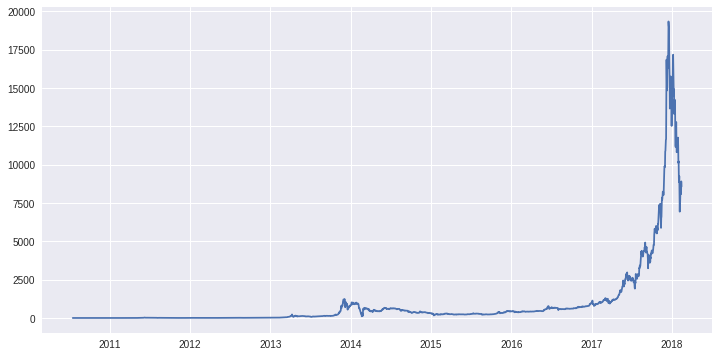

In [3]:
sns.set(rc={'figure.figsize':(12,6)})
plt.plot(df.timestamp, df.close)
df['Date'] = df['timestamp'].dt.strftime('%Y-%m-%d')
df = df.set_index('Date')

# 1. Basic Machine Learning 

We import the bitcoin related features from blockchain.info

In [4]:
df_2 = fetching.fetch.features_bitcoin()
df_2.head()

,transaction_fees,n_transactions,output_volume,estimated_transaction
Date,,,,
2009-01-03,0.0,1.0,50.0,0.0
2009-01-05,0.0,0.0,0.0,0.0
2009-01-07,0.0,0.0,0.0,0.0
2009-01-09,0.0,14.0,700.0,0.0
2009-01-11,0.0,106.0,5300.0,0.0


We create a dictionnary of algorithms we will try

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

clfs = {
'XgBoost': 
'RF': RandomForestClassifier(n_estimators=50),
'KNN': KNeighborsClassifier(n_neighbors=10),
'NB':GaussianNB(),
'CART': tree.DecisionTreeClassifier(),
'DS': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),algorithm="SAMME",n_estimators=50),
'KNN': KNeighborsClassifier(n_neighbors=10),
'GB': GradientBoostingClassifier(n_estimators=50, learning_rate=0.01, max_depth=1, random_state=0),
'AB':AdaBoostClassifier(base_estimator=None, n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=None)
}

We write the function which will run the classifiers we selected in the dictionnary

In [27]:
import time
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler

def  run_classifier(clsf,X,Y,transformed_data='No', print_scores = True):
    """
    clsf: dicitionnary with different methods
    X: données caractéristiques
    Y: target
    transformed_data (optional): Add Normalization or PCA
    """
    
    if transformed_data == "Normalization":
        X=MinMaxScaler().fit_transform(X)
    if transformed_data == "PCA":
        X=preprocessing.MinMaxScaler().fit_transform(X)
        X=PCA(n_components=0.7).fit_transform(X)

    precision=[]
    method=[]
    kf = KFold(n_splits=10, shuffle=True, random_state=0)


    for i in clfs:
        
        if print_scores :
            print("Method {}: ".format(i))
        t0=time.time()
        cv_precision = cross_val_score(clfs[i], X, Y, cv=kf,scoring='precision')
        t1=time.time()
        if print_scores :
            print("Mean précision: {0:.4f}, Ecart-type précision: {1: .6f}, Time: {2:.2f} sec".format(np.mean(cv_precision),np.std(cv_precision),t1-t0))
        precision.append(np.mean(cv_precision))
        method.append(i)
        if print_scores :
            print("")
    return precision,method

# 2. Stocks market approach

## Stocks Market indices 

We calculate a series of stocks market prediction tools, which we will use as features.

In [7]:
def calc_sma(prices, window=30):
    """Returns a Simple Moving Average"""
    return prices['close'].rolling(window=window).mean()

def calc_bollinger_bands(prices, window=30):
    """Returns DataFrame with basic indicators
    Standard Deviation, SMA, and the upper and lower Bollinger bands
    """
    prices['std'] = prices['close'].rolling(window=window).std()
    prices['sma'] = calc_sma(prices, window)
    prices['upper_band'] = prices['sma'] + 3 * prices['std']
    prices['lower_band'] = prices['sma'] - 3 * prices['std']
    prices['band_value'] = (prices['close'] - prices['sma']) / (2 * prices['std'])
    return prices

def calc_momentum(prices, window=1):
    """Indicates whether a stock price has been increasing or decreasing
    for the past x number of days
    """
    prices['momentum'] = (prices['close'] / prices['close'].shift(window) - 1)
    return prices.fillna(0)

def calc_rsi(prices, window=14):
    delta = prices['close'].diff()[1:]
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    
    roll_up = up.rolling(window=window).mean()
    roll_down = down.abs().rolling(window=window).mean()
    
    # Calculate the RSI based on SMA
    rs = roll_up / roll_down
    rsi = 100.0 - (100.0 / (1.0 + rs))
    prices['rsi'] = rsi
    return prices

def calc_william_percent_r(prices, window=14):
    df = prices.copy()
    df['high'] = prices['close'].rolling(window=window).max()
    df['low'] = prices['close'].rolling(window=window).min()
    df['williams'] = (df['high'] - df['close']) / (df['high'] - df['low']) * -100
    prices['williams'] = df['williams']
    return prices

def calc_macd(prices):
    
    df = prices.copy()
    df['ema_12d'] = prices['close'].ewm(ignore_na=False,
                                         span=12,min_periods=0,
                                         adjust=True).mean()
    df['ema_26d'] = prices['close'].ewm(ignore_na=False,
                                         span=26,min_periods=0,
                                         adjust=True).mean()
    df['macd'] = df['ema_12d'] - df['ema_26d']
    df['macd_signal_line'] = df['macd'].rolling(window=9).mean()
    df['macd_historical'] = df['macd'] - df['macd_signal_line']

    prices['macd'] = df['macd_historical']
    return prices
    
def calc_stats(prices, days_out=5, dropna=False, add_params=True):
    """Returns the prices dataframe with the addition of a target value y which indicates if the 
        value has increased after a certain delay
    days_out is the delay in days
    add_params adds every calculated stats to the dataframe if True.    
    """
    prices = calc_bollinger_bands(prices, window=15)
    
    if add_params == True:
        prices = calc_momentum(prices)
        prices['sma_50d'] = calc_sma(prices, window=50)
        prices = calc_rsi(prices)
        prices = calc_william_percent_r(prices)
        prices = calc_macd(prices)

    prices['return'] =  prices['close'].shift(days_out * -1) / prices['close'] - 1
    prices['y'] = prices['return'] > 0
    prices['y'] = prices['y'].apply(lambda x : int(x))
    
    if dropna == True:
        prices = prices.dropna()
    
    prices = prices.drop('return', 1)
    
    return prices

Let's transform our dataframe adding our new stats and the y target value for a delay of 5 days :

In [8]:
df2 = calc_stats(df, days_out=5, dropna=True, add_params=True)

We can now plot the closing value of the prices again, but with its standard moving average and the bollinger bands associated.
(Only the last year is displayed for a better readability)

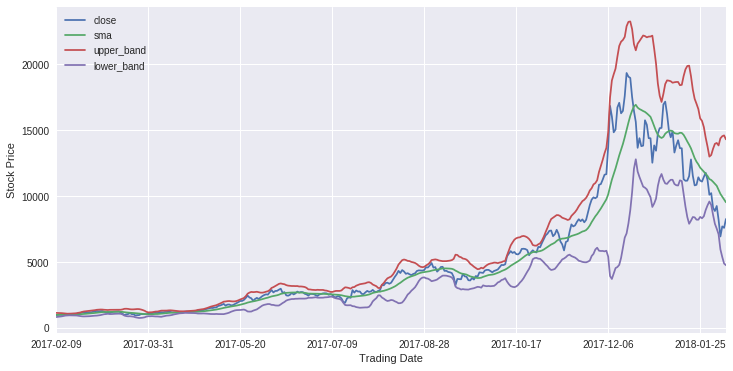

In [9]:
ax = df2[['close', 'sma', 'upper_band', 'lower_band']].iloc[-365:, :].plot()
ax.set_ylabel('Stock Price')
ax.set_xlabel('Trading Date')
print("")

To study the fluctuations, we can compute the exponential moving average, and compare it to the standard one.

In [10]:
df2['ewm'] = df2['close'].ewm(span=20).mean()
df2['dif_moy_mob'] = df2['ewm']-df2['sma']

Let's plot them both on a same graph :

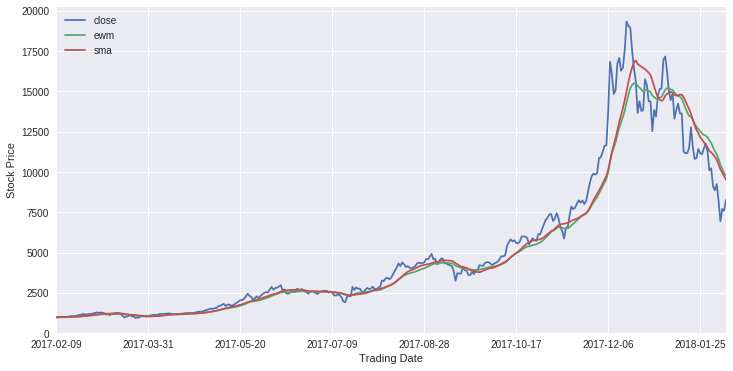

In [11]:
ax = df2[['close', 'ewm', 'sma']].iloc[-365:, :].plot()
ax.set_ylabel('Stock Price')
ax.set_xlabel('Trading Date')
print("")

We run the function to compute the needed analysis stats and add them to our dataset. Then we get rid of the features which can't help our model.

In [12]:
df_1 = calc_stats(df2, days_out=30, dropna=True, add_params=True)
df_1.drop(['time', 'timestamp','volumefrom', 'volumeto'], axis=1, inplace=True)

Then we split the dataset into features and target :

In [13]:
features = df_1[df_1.columns.difference(['y'])]
target =  df_1['y']

And we can finally run our classifiers :

In [14]:
[precision,method]=run_classifier(clfs,features, target)

Method GB: 
Mean précision: 0.6172, Ecart-type précision:  0.020272, Time: 0.77 sec

Method DS: 
Mean précision: 0.6617, Ecart-type précision:  0.032442, Time: 2.54 sec

Method RF: 
Mean précision: 0.9274, Ecart-type précision:  0.016115, Time: 3.24 sec

Method KNN: 
Mean précision: 0.8567, Ecart-type précision:  0.019866, Time: 0.08 sec

Method AB: 
Mean précision: 0.7817, Ecart-type précision:  0.020135, Time: 2.56 sec

Method NB: 
Mean précision: 0.6168, Ecart-type précision:  0.024936, Time: 0.03 sec

Method CART: 
Mean précision: 0.8992, Ecart-type précision:  0.019721, Time: 0.31 sec



We want to compare our previsions for each algorithm depending on the number of days in the future. For this we write a function run_class_rep which runs the run_classifiers function for several values of days_out, and gives as an output the comparison table.

In [15]:
def run_class_rep(days) : 
    tab_rendu_final = pd.DataFrame([])
    for n in days :
        df_1 = calc_stats(df, days_out=n, dropna=True, add_params=True)
        df_1.drop(['time', 'timestamp','volumefrom', 'volumeto'], axis=1, inplace=True)
        features = df_1[df_1.columns.difference(['y'])]
        target =  df_1['y']
        [precision,method]=run_classifier(clfs,features,target,print_scores=False)
        print("For a "+str(n)+" days prevision :")
        #                   PLOT A RAJOUTER !!!
        tab_rendu=pd.DataFrame([])
        tab_rendu['Algo']=method
        tab_rendu = tab_rendu.set_index('Algo')
        tab_rendu['precision for '+str(n)+" days"]=precision
        tab_rendu_final = pd.concat([tab_rendu_final,tab_rendu],axis = 1)
    return tab_rendu_final

Example for 5, 10 and 15 days previsions :

In [16]:
run_class_rep([5,10,15])

For a 5 days prevision :
For a 10 days prevision :
For a 15 days prevision :


,precision for 5 days,precision for 10 days,precision for 15 days
Algo,,,
GB,0.584150,0.597786,0.613296
DS,0.619873,0.645529,0.668726
RF,0.818964,0.874635,0.911405
KNN,0.749960,0.813026,0.847148
AB,0.643109,0.699539,0.743492
NB,0.584590,0.596416,0.612799
CART,0.774541,0.818059,0.851793


We print the confusion matrix for the best classifier found :

In [17]:
from sklearn.metrics import confusion_matrix
random_forest = clfs["RF"]
random_forest.fit(features[:-200], target[:-200])
X = random_forest.predict(features[-200:]) 
confusion_matrix(X, target[-200:])

array([[ 50, 119],
       [  6,  25]])

### Media data import

In [18]:
media = fetching.fetch.media_coverage()
media.head()

,Value
Date,
2017-02-19,0.0199
2017-02-20,0.0291
2017-02-21,0.0332
2017-02-22,0.0379
2017-02-23,0.0423


The data are available for the last year from the day we get them only. We can see what it looks like :

Media coverage evolution :


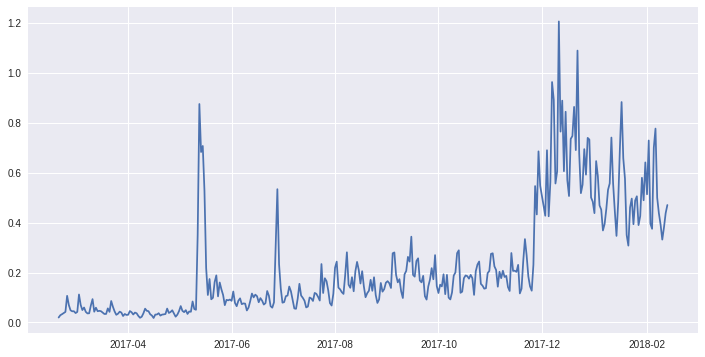

In [19]:
plt.plot(media.Value)
print("Media coverage evolution :")

In [20]:
# on join media à notre table de données, A CHANGER
df_lastyear = df2.join(media).dropna()

In [21]:
df_lastyear = df_lastyear.interpolate()
df_lastyear.head()

,close,high,low,open,time,volumefrom,volumeto,timestamp,std,sma,...,band_value,momentum,sma_50d,rsi,williams,macd,y,ewm,dif_moy_mob,Value
Date,,,,,,,,,,,,,,,,,,,,,
2017-02-19,1048.89,1056.48,1037.67,1052.28,1487462400,17953.15,18876881.86,2017-02-19 01:00:00,25.041176,1021.442667,...,0.548044,-0.003222,951.0594,57.489490,-8.624069,0.957223,1,1006.499496,-14.943170,0.0199
2017-02-20,1077.56,1081.78,1040.99,1048.89,1487548800,31010.85,32959720.15,2017-02-20 01:00:00,28.844193,1025.539333,...,0.901753,0.027334,952.7018,61.067169,-0.000000,3.329733,1,1013.267163,-12.272170,0.0291
2017-02-21,1119.03,1123.03,1073.54,1077.56,1487635200,57048.87,62908569.43,2017-02-21 01:00:00,37.601278,1031.830000,...,1.159535,0.038485,954.7414,63.593316,-0.000000,7.372864,1,1023.339814,-8.490186,0.0332
2017-02-22,1120.46,1132.25,1094.83,1119.03,1487721600,47913.31,53647453.34,2017-02-22 01:00:00,43.915332,1036.556667,...,0.955285,0.001278,956.4846,62.940684,-0.000000,9.461780,1,1032.589356,-3.967311,0.0379
2017-02-23,1171.91,1181.60,1113.54,1120.46,1487808000,65737.10,75663167.44,2017-02-23 01:00:00,56.098299,1044.318000,...,1.137218,0.045919,957.2146,92.697499,-0.000000,13.645028,1,1045.857989,1.539989,0.0423


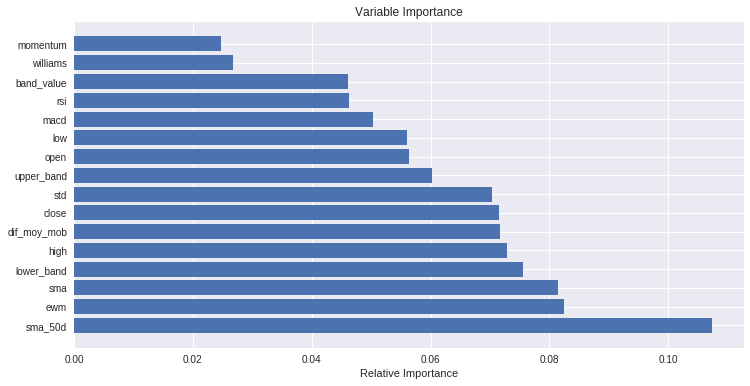

In [23]:
clf=RandomForestClassifier()
X=features
Y=target
clf.fit(X,Y)

importances=clf.feature_importances_
sorted_idx=np.argsort(importances)[::-1]
features_num=np.arange(1,X.shape[1]+1)

padding=np.arange(X.size/len(X))+0.5
plt.barh(padding,importances[sorted_idx],align='center')
plt.yticks(padding,features.columns.values[(features_num[sorted_idx]-1)])
plt.xlabel("Relative Importance")
plt.title("Variable Importance")
plt.show()

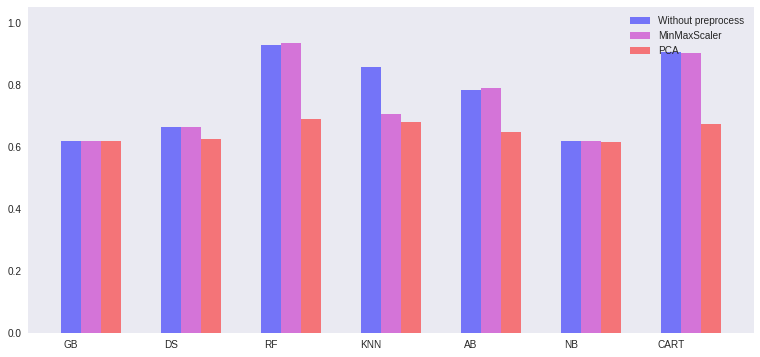

In [28]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

[precision,method]=run_classifier(clfs,features, target, print_scores = False)

transformed_data='Normalization'
[precision1,method1]=run_classifier(clfs,features, target, transformed_data, print_scores = False)

transformed_data='PCA'
[precision2,method2]=run_classifier(clfs,features, target, transformed_data, print_scores = False)

pos = list(range(len(precision)))
width = 0.2
fig, ax = plt.subplots(figsize=(13,6))
plt.bar(pos,
        precision,
        width,
        alpha=0.5,
        color='b')

plt.bar([p + width for p in pos],
        precision1,
        width,
        alpha=0.5,
        color='m')

plt.bar([p + width*2 for p in pos],
        precision2,
        width,
        alpha=0.5,
        color='r')


plt.ylim([0,1.05])
ax.set_xticklabels(['0']+method)
plt.legend(['Without preprocess','MinMaxScaler','PCA'], loc='upper right')
plt.grid()
plt.show()